# Pre-processing


In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 10.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 
plt.set_cmap(plt.cm.bone)
IS_LOCAL = True
import os
import cv2
import skimage
from skimage import feature, filters
from tqdm import tqdm
from sklearn.model_selection import train_test_split

PATH="/content/drive/MyDrive/CIS522/Project/rsna-pneumonia-detection-challenge"

print(os.listdir(PATH))

['stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', '.DS_Store', 'stage_2_test_images', 'stage_2_train_images', 'img_features.csv']


<Figure size 432x288 with 0 Axes>

In [4]:
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [5]:
train_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


## Load dataset

In [6]:
def load_images(data):
    imgs = []
    for path in data['patientId']:
        patientImage = path + '.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/", patientImage)
        img = dcm.read_file(imagePath).pixel_array
        imgs.append(img)
    return imgs

def imshow_gray(img):
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')
    
def imshow_with_labels(img, patient_id):
    rows = train_labels_df[train_labels_df['patientId'] == patient_id]
    for row in rows.itertuples():        
        x, y, w, h = row.x, row.y, row.width, row.height
        x, y, w, h = map(int, [x,y,w,h])
        cv2.rectangle(img, (x,y), (x+w,y+h), 255, 2)
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')

In [8]:
test_df = train_class_df[train_class_df['Target']==1].sample(4)
box = test_df.loc[test_df.index, ['x', 'y', 'width', 'height']]
test = load_images(test_df[0:3])

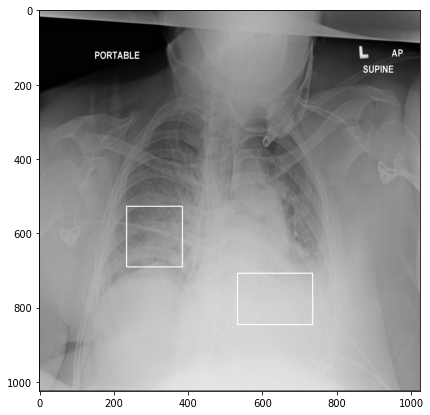

In [9]:
idx = 1
img = test[idx]
imshow_with_labels(img.copy(), test_df.iloc[idx,0])

## Feature extraction
* Area of opacity
* Perimeter of visible lung regions
* Irregularity index
* Equivalent diameter
* Mean, sd of unenhanced image
* Hu moments (5 values)

In [10]:
# binarized image as input
def area(img):
    return np.count_nonzero(img)

# edges of the image as input
def perimeter(img):
    return np.count_nonzero(img)

# area and perimeter of the image as input, also called compactness
def irregularity(area, perimeter):
    Ir = (4 * np.pi * area) / (perimeter ** 2)
    return Ir

# area of image as input
def equiv_diam(area):
    eduiv = np.sqrt((4 * area) / np.pi)
    return eduiv

# hu moments except 3rd and 7th (in total 5 values)
def get_hu_moments(contour):
    # Sometimes body is slightly rotated, and differently sized so we want 
    # center of moment to be invariant to rotation and scale. So we pick Hu 
    # moments. We will log the moments to make it easy to compare and drop 
    # the 3rd moment as it depends on the other moments and 7th moment as it 
    # distinguishes mirror images and there are no flipped images in the dataset
    hu = cv2.HuMoments(cv2.moments(contour)).ravel().tolist()
    del hu[2]
    del hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu

### Feature extraction pipeline

In [11]:
def extract_features(img):
    mean = img.mean()
    std_dev = img.std()
    
    # hist equalization
    equalized = cv2.equalizeHist(img)
    
    # high pass sharpening
    hpf_kernel = np.full((3, 3), -1)
    hpf_kernel[1,1] = 9
    sharpened = cv2.filter2D(equalized, -1, hpf_kernel)
    
    # ostu thresholding
    ret, binarized = cv2.threshold(cv2.GaussianBlur(sharpened,(7,7),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # edge detection
    edges = skimage.filters.sobel(binarized)
    
    # moments from contours
    contours, hier = cv2.findContours((edges * 255).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    select_contour = sorted(contours, key=lambda x: x.shape[0], reverse=True)[0]
    
    # feature extraction
    ar = area(binarized)
    per = perimeter(edges)
    irreg = irregularity(ar, per)
    eq_diam = equiv_diam(ar)
    hu = get_hu_moments(select_contour)
    
    return (mean, std_dev, ar, per, irreg, eq_diam, *hu)

In [ ]:
# test the function
extract_features(img)

(143.57686233520508,
 63.7778973383952,
 526185,
 40601,
 0.004011205081324937,
 818.510567950391,
 -0.72847922595227,
 0.4715583023280535,
 -1.2253665206687707,
 -2.5153789628464738,
 -0.7887874337481455)

# Save features

## Load data
We select only the normal and pneumonia images for model building

In [13]:
pneumonia_ids = train_labels_df[train_labels_df['Target'] == 1]['patientId'].unique()
pneumonia_labels = [1] * len(pneumonia_ids)

normal_ids = class_info_df[class_info_df['class'] == 'Normal']['patientId'].unique()
normal_labels = [0] * len(normal_ids)

data = dict()
data['patientId'] = np.concatenate((pneumonia_ids, normal_ids))
data['target'] = np.concatenate((pneumonia_labels, normal_labels))

print(f'Pneumonia images: {len(pneumonia_ids)}\nNormal images: {len(normal_ids)}')

Pneumonia images: 6012
Normal images: 8851


In [17]:
features = []

for path in tqdm(data['patientId']):
    imagePath = os.path.join(PATH,"stage_2_train_images/", path + '.dcm')
    img = dcm.read_file(imagePath).pixel_array
    feats = extract_features(img)
    features.append(feats)

data['features'] = features

100%|██████████| 14863/14863 [1:42:46<00:00,  2.41it/s]


In [18]:
df = pd.DataFrame(data)
# df.to_csv('img_features.csv')
df.to_csv(PATH+'/img_features.csv')
data = pd.read_csv(PATH+'/img_features.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,patientId,target,features
0,0,0,00436515-870c-4b36-a041-de91049b9ab4,1,"(115.08454608917236, 57.27438506263394, 529785..."
1,1,1,00704310-78a8-4b38-8475-49f4573b2dbb,1,"(92.81453704833984, 74.93762038175163, 498500,..."
2,2,2,00aecb01-a116-45a2-956c-08d2fa55433f,1,"(38.749732971191406, 51.14731838178627, 328949..."
3,3,3,00c0b293-48e7-4e16-ac76-9269ba535a62,1,"(104.95982074737549, 70.30975599712868, 487539..."
4,4,4,00f08de1-517e-4652-a04f-d1dc9ee48593,1,"(110.65030765533447, 58.128343368363296, 52948..."


In [19]:
feats = data.features.apply(lambda x: list(eval(x)))
dataset = pd.DataFrame(feats.values.tolist(), 
                        columns=['mean', 'stddev', 'area', 'perimeter', 'irregularity', 'equiv_diam', 'hu1', 'hu2', 'hu4', 'hu5', 'hu6'],
                       index=data.index)
dataset['label'] = data['target']
dataset.head()

,mean,stddev,area,perimeter,irregularity,equiv_diam,hu1,hu2,hu4,hu5,hu6,label
0,115.084546,57.274385,529785,32447,0.006324,821.305797,-0.696690,-0.727353,-1.364790,2.242547,1.444623,1
1,92.814537,74.937620,498500,33992,0.005422,796.686835,-0.786889,-1.159396,-2.403345,-4.952226,-2.793199,1
2,38.749733,51.147318,328949,23970,0.007195,647.171442,0.774458,3.230857,6.683296,-12.330389,-8.355217,1
3,104.959821,70.309756,487539,46375,0.002849,787.879391,-0.467952,1.008866,-0.450719,0.560254,0.571350,1
4,110.650308,58.128343,529486,58260,0.001960,821.074000,-0.557977,-0.910131,-0.957654,-1.977245,-1.399643,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('label', axis=1), dataset['label'], test_size=0.4, stratify=dataset['label'])

# Models

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

def print_metrics(y_pred, y_train, yt_pred, y_test):
    print('Train data metrics:')
    print('Accuracy: ', accuracy_score(y_train, y_pred))
    print('Precison: ', precision_score(y_train, y_pred))
    print('Recall: ', recall_score(y_train, y_pred))
    print('F1 score: ', f1_score(y_train, y_pred))
    print('ROC AUC score: ', roc_auc_score(y_train, y_pred))
    print()
    print('Test data metrics:')
    print('Accuracy: ', accuracy_score(y_test, yt_pred))
    print('Precison: ', precision_score(y_test, yt_pred))
    print('Recall: ', recall_score(y_test, yt_pred))
    print('F1 score: ', f1_score(y_test, yt_pred))
    print('ROC AUC score: ', roc_auc_score(y_test, yt_pred))

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
parameters = {'C':[1, 5, 10]} 
LogisReg = LogisticRegression()
clf = GridSearchCV(LogisReg, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [1, 5, 10]})

In [45]:
clf.cv_results_

{'mean_fit_time': array([0.17030101, 0.12935004, 0.1653522 ]),
 'mean_score_time': array([0.01597981, 0.00843005, 0.01183372]),
 'mean_test_score': array([0.66019796, 0.66019796, 0.66019796]),
 'param_C': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 5}, {'C': 10}],
 'rank_test_score': array([1, 1, 1], dtype=int32),
 'split0_test_score': array([0.65807175, 0.65807175, 0.65807175]),
 'split1_test_score': array([0.67713004, 0.67713004, 0.67713004]),
 'split2_test_score': array([0.64834549, 0.64834549, 0.64834549]),
 'split3_test_score': array([0.67302299, 0.67302299, 0.67302299]),
 'split4_test_score': array([0.64441952, 0.64441952, 0.64441952]),
 'std_fit_time': array([0.02556395, 0.02179682, 0.03309751]),
 'std_score_time': array([0.00831099, 0.00440297, 0.00511543]),
 'std_test_score': array([0.01300106, 0.01300106, 0.01300106])}

In [46]:
from sklearn.linear_model import LogisticRegression

LogisReg = LogisticRegression()
LogisReg.fit(X_train, y_train)

print_metrics(LogisReg.predict(X_train), y_train, LogisReg.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.6612089267690927
Precison:  0.6534031413612565
Recall:  0.34599390074854447
F1 score:  0.4524197933659597
ROC AUC score:  0.6106617338017675

Test data metrics:
Accuracy:  0.6606121762529431
Precison:  0.6582174979558463
Recall:  0.33471933471933474
F1 score:  0.44377067254685776
ROC AUC score:  0.6083367924655696


## Random Forest

In [ ]:
parameters = {'n_estimators':[600, 700], 'max_depth':[8, 10], 'min_samples_split':[2,5], 'n_jobs':[-1]}

from sklearn.ensemble import RandomForestClassifier
RandForest = RandomForestClassifier()
clf = GridSearchCV(RandForest, parameters)
clf.fit(X_train, y_train)


In [24]:
clf.cv_results_

{'mean_fit_time': array([8.07152724, 9.77718601, 7.05412593, 8.20062366, 8.17649155,
        9.6294239 , 8.13968468, 9.49601393]),
 'mean_score_time': array([0.3464057 , 0.36599698, 0.30462728, 0.36476107, 0.30470605,
        0.4055531 , 0.32548208, 0.3447278 ]),
 'mean_test_score': array([0.77301834, 0.77234519, 0.7743642 , 0.77346658, 0.77907454,
        0.77750403, 0.77885045, 0.77795303]),
 'param_max_depth': masked_array(data=[8, 8, 8, 8, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 2, 5, 5, 2, 2, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[600, 700, 600, 700, 600, 700, 600, 700],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=ob

In [25]:
# best hyper parameter
RandForest = RandomForestClassifier(600, max_depth=10, min_samples_split=2, n_jobs=-1)
RandForest.fit(X_train, y_train)

print_metrics(RandForest.predict(X_train), y_train, RandForest.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.8769765616238645
Precison:  0.8854422604422605
Recall:  0.7992791793734405
F1 score:  0.840157365583564
ROC AUC score:  0.8645171791405809

Test data metrics:
Accuracy:  0.7882610158089471
Precison:  0.7718216318785579
Recall:  0.6765072765072765
F1 score:  0.7210281409262133
ROC AUC score:  0.77033497121043


## Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'n_estimators':[600, 700], 'max_depth':[5, 8], 'min_samples_split':[2,5], 'learning_rate':[0.01, 0.05]}

GradBoost = GradientBoostingClassifier()
clf = GridSearchCV(GradBoost, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [5, 8],
                         'min_samples_split': [2, 5],
                         'n_estimators': [600, 700]})

In [27]:
clf.cv_results_

{'mean_fit_time': array([29.00320344, 33.33429294, 28.2773663 , 33.25940552, 44.57274179,
        51.95284805, 43.54305983, 51.54076047, 28.86258349, 33.63166099,
        28.84143686, 33.40034466, 45.05838976, 51.85427532, 43.96009626,
        58.29235182]),
 'mean_score_time': array([0.034903  , 0.03875303, 0.03494539, 0.03934793, 0.06038833,
        0.06681724, 0.05790372, 0.06434164, 0.02734928, 0.0312777 ,
        0.02702231, 0.0298769 , 0.04663153, 0.05198379, 0.04457445,
        0.05133481]),
 'mean_test_score': array([0.78838293, 0.78737365, 0.78703764, 0.78793444, 0.78546631,
        0.78591512, 0.78625201, 0.78524229, 0.78501776, 0.78636361,
        0.78557949, 0.78546776, 0.78378489, 0.7824389 , 0.78400948,
        0.78333608]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05,
                    0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
              mask=[False, False, False, False, False, False, False, False,
               

In [51]:
# best hyper parameter
GradBoost = GradientBoostingClassifier(n_estimators=400, learning_rate=0.01,
                               max_depth=5, min_samples_split=2)
GradBoost.fit(X_train, y_train)

print_metrics(GradBoost.predict(X_train), y_train, GradBoost.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.8321184254794213
Precison:  0.8208637469586375
Recall:  0.748267258109232
F1 score:  0.7828861493836113
ROC AUC score:  0.8186722354576291

Test data metrics:
Accuracy:  0.7917928018836192
Precison:  0.7715216379711494
Recall:  0.6893970893970894
F1 score:  0.7281510759771629
ROC AUC score:  0.7753678471554778


## SVM

In [35]:
from sklearn.svm import SVC

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [36]:
clf.cv_results_

{'mean_fit_time': array([29.16620908,  3.61116438, 40.955055  ,  5.51780634]),
 'mean_score_time': array([0.1823163 , 0.65564585, 0.19087496, 1.06586137]),
 'mean_test_score': array([0.6605346 , 0.65167614, 0.65941308, 0.66165643]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'}],
 'rank_test_score': array([2, 4, 3, 1], dtype=int32),
 'split0_test_score': array([0.65639013, 0.64686099, 0.65639013, 0.65695067]),
 'split1_test_score': array([0.67769058, 0.6603139 , 0.67600897, 0.67600897]),
 'split2_test_score': array([0.64946719, 0.64778463, 0.65002804, 0.65002804]),
 'split3_test_score': 

In [37]:
# best hyper parameter
svm = SVC(kernel='rbf',C=10)
svm.fit(X_train, y_train)

print_metrics(svm.predict(X_train), y_train, svm.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.6630032522148704
Precison:  0.6977660972404731
Recall:  0.29442750207929025
F1 score:  0.4141158120491324
ROC AUC score:  0.6038992500980256

Test data metrics:
Accuracy:  0.6626303397241843
Precison:  0.7041965199590583
Recall:  0.2860706860706861
F1 score:  0.4068598462448256
ROC AUC score:  0.6022276615894239


## KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':[5, 7, 10]}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7, 10]})

In [31]:
clf.cv_results_

{'mean_fit_time': array([0.01205654, 0.01169057, 0.01194601]),
 'mean_score_time': array([0.0580327 , 0.05873547, 0.06059318]),
 'mean_test_score': array([0.67320728, 0.67802999, 0.68756178]),
 'param_n_neighbors': masked_array(data=[5, 7, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5}, {'n_neighbors': 7}, {'n_neighbors': 10}],
 'rank_test_score': array([3, 2, 1], dtype=int32),
 'split0_test_score': array([0.68273543, 0.68834081, 0.69282511]),
 'split1_test_score': array([0.67432735, 0.67432735, 0.69394619]),
 'split2_test_score': array([0.66517106, 0.67358385, 0.68311834]),
 'split3_test_score': array([0.67470555, 0.68087493, 0.69265283]),
 'split4_test_score': array([0.66909703, 0.67302299, 0.6752664 ]),
 'std_fit_time': array([0.00070946, 0.00019246, 0.00047283]),
 'std_score_time': array([0.00526695, 0.00302981, 0.00379381]),
 'std_test_score': array([0.00592891, 0.0058814 , 0.00728426])}

In [32]:
# best hyper parameter
knn = KNeighborsClassifier(10)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_train), y_train, knn.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.7384770662778961
Precison:  0.7406568516421291
Recall:  0.5439423343498753
F1 score:  0.6272378516624041
ROC AUC score:  0.7072819016382145

Test data metrics:
Accuracy:  0.6878573831146989
Precison:  0.6536094012311136
Recall:  0.4856548856548857
F1 score:  0.5572519083969466
ROC AUC score:  0.6554227548861833


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:252: YellowbrickWarning: both classes and encoder specified, using encoder
  "both classes and encoder specified, using encoder", YellowbrickWarning
/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:252: YellowbrickWarning: both classes and encoder specified, using encoder
  "both classes and encoder specified, using encoder", YellowbrickWarning
/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:310: YellowbrickWarning: both classes and encoder specified, using encoder
  "both classes and encoder specified, using encoder", YellowbrickWarning
/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:310: YellowbrickWarning: both classes and encoder specifi

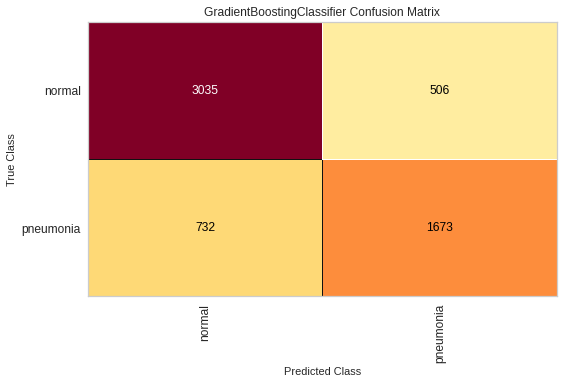

In [34]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(GradBoost, classes=[0,1], 
                     encoder={0: 'normal', 1: 'pneumonia'})
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [ ]:
import skimage
from skimage import feature, filters

In [ ]:
# PATH = '../input/rsna-pneumonia-detection-challenge'

def load_image(path):    
    patientImage = path + '.dcm'
    imagePath = os.path.join(PATH,"stage_2_train_images/", patientImage)
    img = dcm.read_file(imagePath).pixel_array
    return img

def imshow_gray(img):
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')

def area(img):
    return np.count_nonzero(img)

def perimeter(img):
    return np.count_nonzero(img)

def irregularity(area, perimeter):
    Ir = (4 * np.pi * area) / (perimeter ** 2)
    return Ir

def equiv_diam(area):
    ed = np.sqrt((4 * area) / np.pi)
    return ed

def get_hu_moments(contour):
    hu = cv2.HuMoments(cv2.moments(contour)).ravel().tolist()
    del hu[2]
    del hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu


def extract_features(img):
    mean = img.mean()
    std_dev = img.std()
    
    # hist equalization
    equalized = cv2.equalizeHist(img)
    
    # sharpening
    hpf_kernel = np.full((3, 3), -1)
    hpf_kernel[1,1] = 9
    sharpened = cv2.filter2D(equalized, -1, hpf_kernel)
    
    # thresholding
    ret, binarized = cv2.threshold(cv2.GaussianBlur(sharpened,(7,7),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # edge detection
    edges = skimage.filters.sobel(binarized)
    
    # moments from contours
    contours, hier = cv2.findContours((edges * 255).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    select_contour = sorted(contours, key=lambda x: x.shape[0], reverse=True)[0]
    
    
    # feature extraction
    ar = area(binarized)
    per = perimeter(edges)
    irreg = irregularity(ar, per)
    eq_diam = equiv_diam(ar)
    hu = get_hu_moments(select_contour)
    
    return (mean, std_dev, ar, per, irreg, eq_diam, *hu)

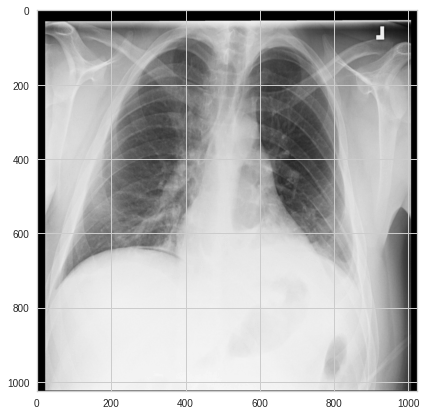

In [ ]:
test_img = data[data['target']==1]['patientId'].sample(1)

img = load_image(test_img.values[0])
imshow_gray(img)

In [ ]:
feats = list(extract_features(img))

pred = gb.predict([feats])

if pred == 1:
    print('Patient is infected with pneumonia')
else:
    print('Patient is normal')

Patient is normal


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


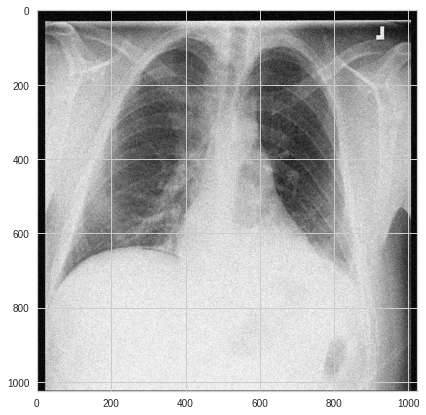

In [ ]:
from skimage.util import random_noise

img = random_noise(img, mode='gaussian')
img = (img*255).astype('int')
imshow_gray(img)

In [ ]:
feats = list(extract_features(img.astype('uint8')))

pred = GradBoost.predict([feats])

if pred == 1:
    print('Patient is infected with pneumonia')
else:
    print('Patient is normal')

Patient is normal


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
